# Vehicle Detection

### Train Classifier

In [38]:
#Utility Functions

import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import math
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    print("Extracting features...")
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs[0]:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(img)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, (math.ceil(bbox[0][0]), math.ceil(bbox[0][1])), (math.ceil(bbox[1][0]), math.ceil(bbox[1][1])), color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [39]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

def train_classifier(X_train, X_test, y_train, y_test, data_supplied=False):
    X_scaler = None
    if data_supplied == False:
        print("Reading data from disk....")
        cars = []
        notcars = []

        # Read in car and non-car images
        images = glob.glob('dataset_small/non_vehicles_smallset/all_non_cars/*.jpeg')

        for image in images:
            notcars.append(images)

        images = glob.glob('dataset_small/vehicles_smallset/all_cars/*.jpeg')
        for image in images:
            cars.append(images)

        # Parameters to tune
        spatial = 32
        histbin = 32

        car_features = extract_features(cars, color_space='RGB', spatial_size=(spatial, spatial),
                                hist_bins=histbin, hist_range=(0, 256))
        notcar_features = extract_features(notcars, color_space='RGB', spatial_size=(spatial, spatial),
                                hist_bins=histbin, hist_range=(0, 256))

        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        print('Using spatial binning of:',spatial,
            'and', histbin,'histogram bins')
        print('Feature vector length:', len(X_train[0]))
    
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc, X_scaler

### Search and Classify

In [40]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, scale = 1.0, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True): 
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[int(window[0][1]):int(window[1][1]), int(window[0][0]):int(window[1][0])], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows    

### Test classifier training

In [41]:
###  Hyper Params
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

cars = []
notcars = []

# Read in car and non-car images
images = glob.glob('dataset_small/non_vehicles_smallset/all_non_cars/*.jpeg')

for image in images:
    notcars.append(images)

images = glob.glob('dataset_small/vehicles_smallset/all_cars/*.jpeg')
for image in images:
    cars.append(images)
    
test_image = mpimg.imread('test_images/test1.jpg')
y_start_stop = [test_image.shape[0]/2, test_image.shape[0]]

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc , x_scaler = train_classifier(X_train, X_test, y_train, y_test, data_supplied=True)

Extracting features...


/Users/hdayanidhi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Extracting features...
0.06 Seconds to train SVC...
Test Accuracy of SVC =  0.9935
My SVC predicts:  [ 0.  0.  0.  1.  1.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
0.00125 Seconds to predict 10 labels with SVC


### Test search and classify

/Users/hdayanidhi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


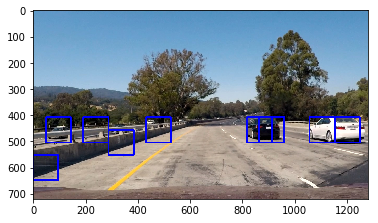

In [42]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
cv2.imwrite("output_images/test1_op.jpg", cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR))
plt.imshow(window_img)
plt.show()

### Run search and classify mutiple times with multiple hyper params to get better fit and also to get better detections

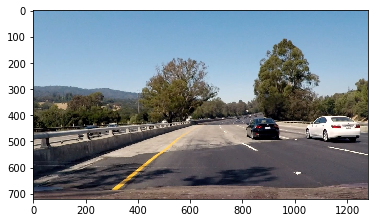

In [ ]:
# Test search and classify
image_orig = mpimg.imread('test_images/test4.jpg')
plt.imshow(image_orig)
plt.show()
draw_image = np.copy(image_orig)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

# Run this multiple times with different hyper params
y_start_stop = [None, None]

all_hot_windows = []

##############1###################
imshape = image_orig.shape
y_start_stop[0] = imshape[0]/2
y_start_stop[1] = imshape[0]
windows = slide_window(image_orig, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image_orig, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

all_hot_windows.append(hot_windows)

##############2###################

imshape = image_orig.shape
y_start_stop[0] = imshape[0]/2 + 40
y_start_stop[1] = imshape[0]
windows = slide_window(image_orig, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image_orig, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

all_hot_windows.append(hot_windows)

##############3###################

imshape = image_orig.shape
y_start_stop[0] = imshape[0]/2
y_start_stop[1] = imshape[0]
windows = slide_window(image_orig, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(50, 50), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image_orig, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

all_hot_windows.append(hot_windows)

##############4#####################

imshape = image_orig.shape
y_start_stop[0] = imshape[0]/2 + 40
y_start_stop[1] = imshape[0]
windows = slide_window(image_orig, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(50, 50), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image_orig, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

all_hot_windows.append(hot_windows)

##########################################

all_hot_windows = [hot_window for hot_windows in all_hot_windows for hot_window in hot_windows]

window_img = draw_boxes(draw_image, all_hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()

### Multiple Detections and False Positives

In [ ]:
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[int(box[0][1]):int(box[1][1]), int(box[0][0]):int(box[1][0])] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labels(heatmap):
    return label(heatmap)

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    blank = np.zeros_like(img[:,:,0])
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        blank = cv2.rectangle(blank, bbox[0], bbox[1], (0,0,255), 6)
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, blank

Testing heatmaps

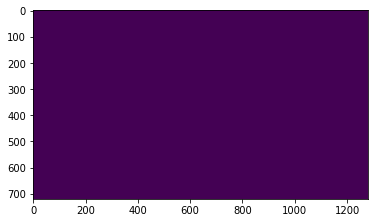

In [120]:
heatmap = np.zeros_like(image_orig[:,:,0])
heatmap = add_heat(heatmap, all_hot_windows)
thresholded = apply_threshold(heatmap, 5)
labels = get_labels(thresholded)
final_image, blank = draw_labeled_bboxes(image_orig, labels)
cv2.imwrite("output_images/test4_op_heatmap.jpg", (128*thresholded))
cv2.imwrite("output_images/test4_op_final_bounding.jpg",cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
plt.imshow(thresholded)
plt.show()

### Putting it all together
1. Train classifier
2. Search and classify
3. Add heat
4. Remove heatmaps below a threshold
5. Draw bounding boxes

In [31]:
def search_and_classify(image):
    global y_start_stop
    y_start_stop = [image.shape[0]/2, image.shape[0]]

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    return window_img, hot_windows

In [32]:
def pipeline(img):
   zero_image = np.zeros_like(img[:,:,0])
   classified_raw_image, bboxes = search_and_classify(img)
   return classified_raw_image
   heatmap = add_heat(zero_image, bboxes)
   heatmap = apply_threshold(heatmap,2)
   labels = get_labels(heatmap)
   draw_img, blank = draw_labeled_bboxes(np.copy(img), labels)
   return draw_img

### Test Pipeline

/Users/hdayanidhi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


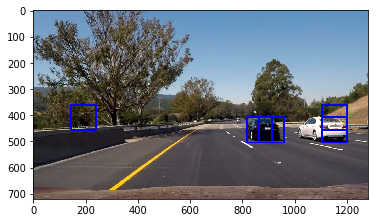

In [37]:
threshold = 0
previous_cycle_bboxes = []
# Read in the last image above
image = mpimg.imread('test_images/test5.jpg')
# Draw bounding boxes on a copy of the image
draw_img = pipeline(image)
# Display the image
plt.imshow(draw_img)
plt.show()

Final Pipeline

In [99]:
def pipeline_final(img):
    
    all_hot_windows = []
    imshape = img.shape
    y_start_stop[0] = imshape[0]/2
    y_start_stop[1] = imshape[0]
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=(0.85, 0.85))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    all_hot_windows.append(hot_windows)
    
    y_start_stop[0] = imshape[0]/2 + 40
    y_start_stop[1] = imshape[0]
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.50, 0.50))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    all_hot_windows.append(hot_windows)
    
    imshape = img.shape
    y_start_stop[0] = imshape[0]/2
    y_start_stop[1] = imshape[0]
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(50, 50), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    all_hot_windows.append(hot_windows)

    ##############4#####################

    
    imshape = img.shape
    y_start_stop[0] = imshape[0]/2 + 40
    y_start_stop[1] = imshape[0]
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(50, 50), xy_overlap=(0.85, 0.85))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    all_hot_windows.append(hot_windows)

    ##########################################
    
    all_hot_windows = [hot_window for hot_windows in all_hot_windows for hot_window in hot_windows]
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, all_hot_windows)
    heatmap_img = apply_threshold(heatmap_img, 5)
    labels = label(heatmap_img)
    draw_img, blank = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [100]:
from moviepy.editor import VideoFileClip

In [101]:
output = 'test_video_op.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline_final)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_op.mp4
[MoviePy] Writing video test_video_op.mp4


 41%|████      | 16/39 [05:57<08:27, 22.06s/it]

KeyboardInterrupt: 

In [268]:
output = 'project_video_op.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_op.mp4
[MoviePy] Writing video project_video_op.mp4


100%|█████████▉| 1260/1261 [04:54<00:00,  4.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_op.mp4 

CPU times: user 4min 48s, sys: 3.65 s, total: 4min 51s
Wall time: 4min 54s


In [291]:
output = 'single_white_car_op.mp4'
clip1 = VideoFileClip("single_white_car.mp4")
white_clip = clip1.fl_image(pipeline_final)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video single_white_car_op.mp4
[MoviePy] Writing video single_white_car_op.mp4


 99%|█████████▉| 165/166 [07:57<00:02,  2.61s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: single_white_car_op.mp4 

CPU times: user 7min 51s, sys: 2.83 s, total: 7min 53s
Wall time: 7min 58s


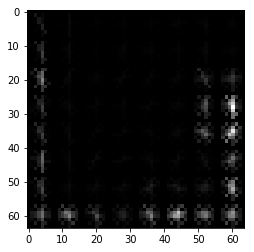

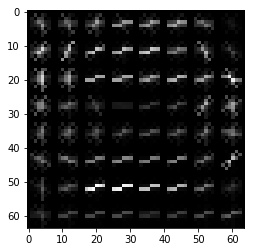

In [239]:
# Produce all the visualizations
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import math
# Define a function to return HOG features and visualization

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


images = glob.glob('dataset_small/non_vehicles_smallset/all_non_cars/extra00.jpeg')
hog_image = None
for image in images:
        img = mpimg.imread(image)
        features, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)

#print(hog_image)
plt.imshow(hog_image, cmap='gray')
plt.show()

images = glob.glob('dataset_small/vehicles_smallset/all_cars/31.jpeg')
hog_image = None
for image in images:
        img = mpimg.imread(image)
        features, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)

#print(hog_image)
plt.imshow(hog_image, cmap='gray')
plt.show()